# Baseline Model - Deep Learning with Windows Slicing

## 1. Windows Slicing 

In [1]:
import scipy.io
import pandas as pd
root = '/Users/apple/PycharmProjects/ESS/ESS/data/NASA/'

In [2]:
def save2df(root,name):
    temp= pd.read_csv(root+ name)
    return temp

In [3]:
B5Charge = save2df(root,'B0005_Charge.csv')
B5Discharge = save2df(root,'B0005_Discharge.csv')
B6Charge = save2df(root,'B0006_Charge.csv')
B6Discharge = save2df(root,'B0006_Discharge.csv')
B7Charge = save2df(root,'B0007_Charge.csv')
B7Discharge = save2df(root,'B0007_Discharge.csv')
B18Charge = save2df(root,'B0018_Charge.csv')
B18Discharge = save2df(root,'B0018_Discharge.csv')

In [291]:
import numpy as np
def data_pre(df):
    x1 = np.arange(df.shape[0])
    # Convert Time_root to cycle 
    unique_ar = np.unique(df[['Time_root']])
    cycle_index = np.arange(unique_ar.shape[0])
    zipbObj = zip(unique_ar, cycle_index)
    dictOfWords = dict(zipbObj)
    df['Cycle'] = df['Time_root'].map(dictOfWords)
    return df 

In [5]:
B5Charge = data_pre(B5Charge)
B5Discharge = data_pre(B5Discharge)
B6Charge = data_pre(B6Charge)
B6Discharge = data_pre(B6Discharge)
B7Charge = data_pre(B7Charge)
B7Discharge = data_pre(B7Discharge)
B18Charge = data_pre(B18Charge)
B18Discharge = data_pre(B18Discharge)

In [51]:
# Mapping discharge capacity to charge dataframe 
df2 = B5Discharge[['Cycle','Capacity']]
map_df = df2.groupby(['Cycle','Capacity']).size().reset_index().rename(columns={0:'count'})

Note that: only B5Discharge datasets has nominal capacity value. However, we could consider charge datasets also have same nominal capacity value. It means that, cycle 120 discharge has capacity X, we could conclude that cycle 120 charge also has capacity X. 

In [60]:
B5Charge_Cap = pd.merge(B5Charge, map_df, on="Cycle", how="left").dropna()

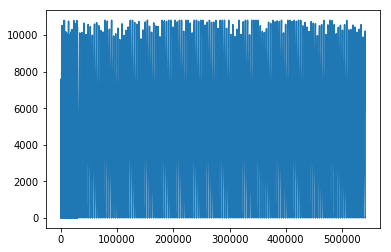

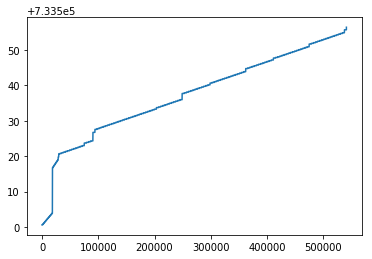

In [62]:
import matplotlib.pyplot as plt
x = np.arange(B5Charge.shape[0])
plt.plot(x,np.array(B5Charge.Time))
plt.show()
x = np.arange(B5Charge.shape[0])
plt.plot(x,np.array(B5Charge.Time_root))
plt.show()

In [63]:
import math
def window_slice(df,width):
    cycle = np.arange(0,160,1).tolist()
    slice_all = []
    for i in range(len(cycle)):
        filter_rows = df.loc[df['Cycle'] == cycle[i]]
        size = filter_rows.shape[0]
        n_slice = math.ceil(size/width)
        slice_ls = []
        for j in range(n_slice):
            if j == (n_slice-1):
                # Lets ignore the tail first
                # slice_row = filter_rows[j*width_length:]
                break
            else:
                slice_row = np.array(filter_rows[j*width:(j+1)*width])
            slice_ls.append(slice_row)
        slice_cycle = np.stack(slice_ls,axis=0)
        slice_all.append(slice_cycle)
    slice_all = np.concatenate(slice_all,axis=0)
    return slice_all

In [313]:
slice_charge = window_slice(B5Charge_Cap,20)

In [316]:
from sklearn.preprocessing import OneHotEncoder
X = slice_charge[:,:,[0,2,3,4,5,6,7,8]]
Y_class = slice_charge[:,:,8][:,0]
Y_reg = slice_charge[:,:,9][:,0]
ohe_Y = OneHotEncoder()
Y_onehot = ohe_Y.fit_transform(Y_class.reshape(-1,1)).toarray()

In [356]:
B5Charge_Cap.columns

Index(['Temperature_root', 'Time_root', 'Time', 'Voltage_measured',
       'Current_measured', 'Temperature_measured', 'Current_charge',
       'Voltage_charge', 'Cycle', 'Capacity', 'count'],
      dtype='object')

## 2. Build Model (PYTORCH)

1. Charging/Discharging Only: 
LSTM(Sequential Extractor) + CNN(Auto Encoder) -> FC (Cycle Prediction) -> FC(Capacity Prediction)

2. Discharge(Encoder) + Charge (Encoder) -> FC (Cycle Prediction) -> FC(Capacity Prediction)

Let's try using charging data only.

In [318]:
# MIN-MAX Normalization 
MIN = X.min()
MAX = X.max()
X = (X-MIN)/MAX
print(X.shape)

(25340, 20, 8)


In [319]:
def comp_loss(logits,labels):
    loss = nn.BCEWithLogitsLoss()(logits,labels)
    loss *= labels.size(1)
    return loss 

In [339]:
import torch.nn as nn
import torch.optim as optim
class CyclePre(nn.Module):
    def __init__(self):
        super(CyclePre, self).__init__()
        self.lstm = nn.LSTM(8,8)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(160,240)
        self.fc2 = nn.Linear(240,160)
        self.sig = nn.Sigmoid()
        self.dropout = nn.Dropout(0.3)

    def forward(self,X):
        x,_ = self.lstm(X)
        x = x.view(x.shape[0],-1)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x 

In [340]:
def compute_acc(logits,TrainY):
    a_labels = torch.max(TrainY, 1)[1].data
    predicts = torch.max(logits, 1)[1].data 
    correct = (predicts == a_labels).sum().item()
    acc = correct/ logits.size(0)
    return acc, correct

In [343]:
def evaluate(val_sub_indices,X,Y_class,net):
    V_loss = 0.0
    num_batch = math.ceil(val_sub_indices.shape[0]/batch)
    correct = 0
    for i in range(num_batch):
        if i == (num_batch-1):
            indices = val_sub_indices[i*batch:]
            TestX = X[indices]
            TestY = Y_onehot[indices]
        else:
            indices = train_sub_indices[i*batch:(i+1)*batch]
            TestX = X[indices]
            TestY = Y_onehot[indices]
        logits = net(TestX)
        loss = comp_loss(logits,TestY)
        V_loss += loss.data[0] * TestY.size(0)
        batch_acc, batch_correct = compute_acc(logits,TestY)
        correct += batch_correct
    V_loss /= val_sub_indices.shape[0]
    print(correct)
    val_acc = 100 * correct / val_sub_indices.shape[0]
    return V_loss, val_acc


In [352]:
net = CyclePre()
optimizer = optim.Adam(net.parameters())
import random
best_eval_acc = 0
batch = 512
train_range = 20000
sample = 20000
val_range = 25000
val_sample = 5000
X = torch.Tensor(X)
Y_onehot = torch.Tensor(Y_onehot)
correct = 0
for epoch in range(100):  # loop over the dataset multiple times
    batch_correct = 0 
    running_loss = 0.0
    train_sub_indices = np.array(random.sample(range(0,train_range),sample))
    val_sub_indices = np.array(random.sample(range(train_range,val_range),val_sample))
    num_batch = math.ceil(train_sub_indices.shape[0]/batch)
    for i in range(num_batch):
        if i == (num_batch-1):
            indices = train_sub_indices[i*batch:]
            TrainX = X[indices]
            TrainY = Y_onehot[indices]
        else:
            indices = train_sub_indices[i*batch:(i+1)*batch]
            TrainX = X[indices]
            TrainY = Y_onehot[indices]
        logits = net(TrainX)
        loss= comp_loss(logits,TrainY)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.data[0] * TrainY.size(0)
        batch_acc, batch_correct = compute_acc(logits,TrainY)
        correct += batch_correct 
    running_loss /= train_sub_indices.shape[0]
    train_acc = 100 * correct / train_sub_indices.shape[0]
    val_loss, val_acc = evaluate(val_sub_indices,X,Y_class,net)
    print('epoch %d' %(epoch))
    print('\t train_loss: %.5f, score: %.3f' %(running_loss,train_acc))
    print('\t val_loss: %.5f, score: %.3f' %(val_loss,val_acc))
    if val_acc>best_eval_acc:
        model_path = root + 'cycle.pth'
        torch.save(net,model_path)
        print('model will be saved this epoch good %s'%model_path)
        best_eval_acc = val_acc

/Users/apple/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/Users/apple/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  app.launch_new_instance()


39
epoch 0
	 train_loss: 49.48895, score: 0.775
	 val_loss: 6.60784, score: 0.780
model will be saved this epoch good /Users/apple/PycharmProjects/ESS/ESS/data/NASA/cycle.pth


/Users/apple/anaconda3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type CyclePre. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


49
epoch 1
	 train_loss: 6.56172, score: 1.655
	 val_loss: 6.10446, score: 0.980
model will be saved this epoch good /Users/apple/PycharmProjects/ESS/ESS/data/NASA/cycle.pth
52
epoch 2
	 train_loss: 5.95507, score: 2.525
	 val_loss: 6.10050, score: 1.040
model will be saved this epoch good /Users/apple/PycharmProjects/ESS/ESS/data/NASA/cycle.pth
36
epoch 3
	 train_loss: 5.93700, score: 3.445
	 val_loss: 6.15198, score: 0.720
36
epoch 4
	 train_loss: 5.92707, score: 4.435
	 val_loss: 6.17534, score: 0.720
36
epoch 5
	 train_loss: 5.92382, score: 5.375
	 val_loss: 6.18592, score: 0.720
33
epoch 6
	 train_loss: 5.92212, score: 6.390
	 val_loss: 6.19553, score: 0.660
57
epoch 7
	 train_loss: 5.91678, score: 7.340
	 val_loss: 6.21725, score: 1.140
model will be saved this epoch good /Users/apple/PycharmProjects/ESS/ESS/data/NASA/cycle.pth
46
epoch 8
	 train_loss: 5.91176, score: 8.205
	 val_loss: 6.23877, score: 0.920
32
epoch 9
	 train_loss: 5.90730, score: 9.215
	 val_loss: 6.23606, score

32
epoch 97
	 train_loss: 5.81081, score: 88.625
	 val_loss: 6.38883, score: 0.640
40
epoch 98
	 train_loss: 5.81176, score: 89.515
	 val_loss: 6.38673, score: 0.800
56
epoch 99
	 train_loss: 5.81160, score: 90.425
	 val_loss: 6.39611, score: 1.120


In [355]:
compute_acc(net(X),Y_onehot)

(0.009037095501183898, 229)

## 3. Build Model (KERAS)

In [374]:
from keras.layers import LSTM, Dense,Flatten
from keras.models import Sequential 
model = Sequential()
model.add(LSTM(units = 8,return_sequences = False,input_shape=(20,8),activation='relu'))
model.add(Dense(units = 160, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='sgd')

In [375]:
from sklearn.preprocessing import OneHotEncoder
X = slice_charge[:,:,[0,2,3,4,5,6,7,8]]
Y_class = slice_charge[:,:,8][:,0]
Y_reg = slice_charge[:,:,9][:,0]
ohe_Y = OneHotEncoder()
Y_onehot = ohe_Y.fit_transform(Y_class.reshape(-1,1)).toarray()

In [376]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 8)                 544       
_________________________________________________________________
dense_4 (Dense)              (None, 160)               1440      
Total params: 1,984
Trainable params: 1,984
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X,Y_onehot,batch_size=18,epochs=5,verbose=2,validation_split=0.2)

Train on 20272 samples, validate on 5068 samples
Epoch 1/5
 - 33s - loss: 5.0373 - val_loss: 5.1808
Epoch 2/5
 - 32s - loss: 5.0311 - val_loss: 5.1993
Epoch 3/5
 - 30s - loss: 5.0251 - val_loss: 5.2180
Epoch 4/5
 - 33s - loss: 5.0192 - val_loss: 5.2369
Epoch 5/5
